# Parametric method 

To implement a parametric approach for time series prediction intervals, we can use a library like Darts. The strategy involves assuming that the forecast residuals (errors) are normally distributed. This allows the model to generate a probabilistic forecast by sampling from this assumed normal distribution. A good, well-known dataset for this is the monthly number of airline passengers (AirPassengers.csv).
The following Python notebook-style example shows how to:

- Load the data and prepare it for forecasting.
- Train a forecasting model (in this case, Exponential Smoothing).
- Generate a probabilistic forecast with prediction intervals.
- Visually inspect the forecast and the prediction interval.

# Setup and data preparation

In [ ]:
# Install Darts, pandas, and matplotlib if you don't have them
# !pip install darts pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mape

# Define the URL for the Air Passengers dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

# Use pandas to read the CSV directly from the URL
df = pd.read_csv(url, delimiter=',', parse_dates=['Month'])
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df.set_index('Month', inplace=True)

# Convert the pandas DataFrame to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, value_cols='Passengers')

# Split the dataset into training and validation sets
# We will use the last 36 months for validation to check the performance.
train, val = series[:-36], series[-36:]

# Plot the training and validation data
plt.figure(figsize=(12, 6))
train.plot(label='Training Data')
val.plot(label='Validation Data')
plt.title('Air Passengers Time Series')
plt.legend()
plt.show()

# Build and train the model

Next, we will fit an Exponential Smoothing model to the training data. This is a classic forecasting method that works well on data with trends and seasonality.

In [ ]:
# Fit an exponential smoothing model
model = ExponentialSmoothing()
model.fit(train)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=None, kwargs=None)

# Generate and visualize the prediction intervals

Now we will generate the probabilistic forecast. The Darts model can do this by simulating many possible future paths, assuming the residuals are normally distributed. You can specify the number of samples you want (num_samples). A higher number of samples gives a smoother prediction distribution.

The plot shows the forecast as a shaded region. The darker central line represents the median prediction, while the shaded area shows the 95% prediction interval. It clearly widens over time, reflecting the increasing uncertainty of the forecast as it extends further into the future.


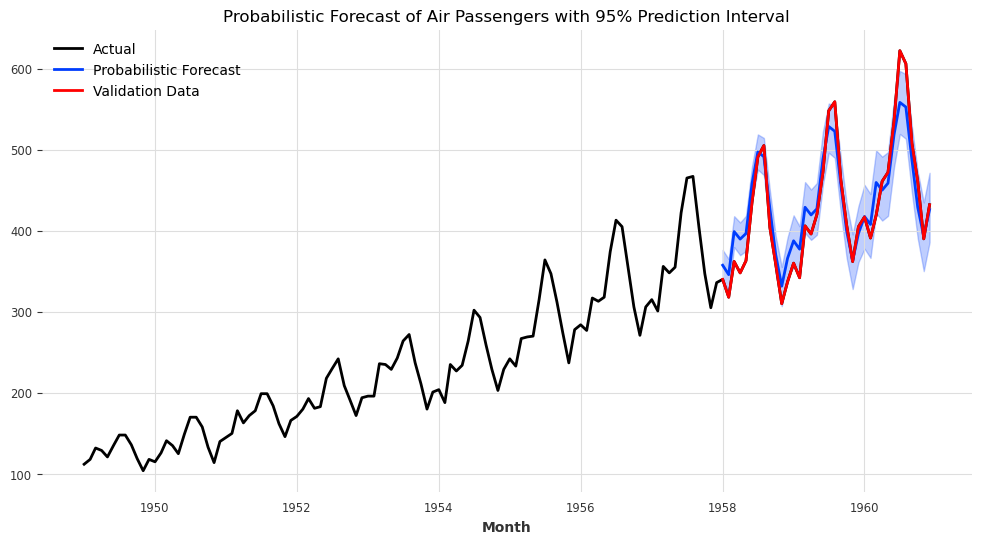

In [ ]:
# Generate a probabilistic forecast for the length of the validation set
# We use num_samples=1000 to get a robust prediction distribution
forecast_probabilistic = model.predict(len(val), num_samples=1000)

# Plot the results
plt.figure(figsize=(12, 6))
series.plot(label='Actual')
forecast_probabilistic.plot(label='Probabilistic Forecast', low_quantile=0.05, high_quantile=0.95)
val.plot(label='Validation Data', color='red')
plt.title('Probabilistic Forecast of Air Passengers with 95% Prediction Interval')
plt.legend()
plt.show()

# Analyze the residuals to confirm normality

For this parametric method to be appropriate, the model residuals should ideally be normally distributed with a mean of zero. We can perform a quick diagnostic check of the residuals.

The Q-Q plot helps visually confirm if the residuals align with a normal distribution. If the points fall along the red line, the assumption holds. If not, a non-parametric method like bootstrapping might be more appropriate.

`start` position `0` corresponding to time `1949-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `1951-01-01 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.


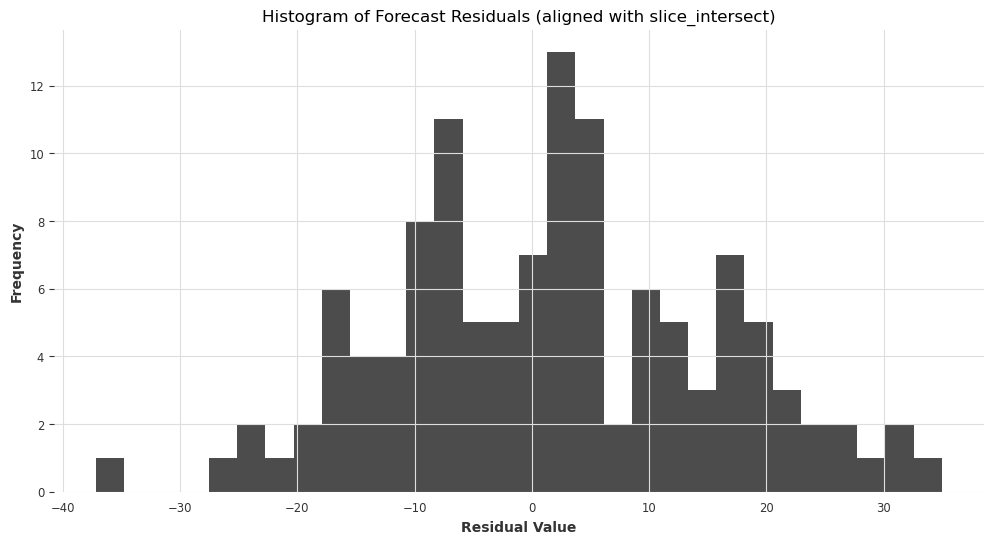

<Figure size 600x600 with 0 Axes>

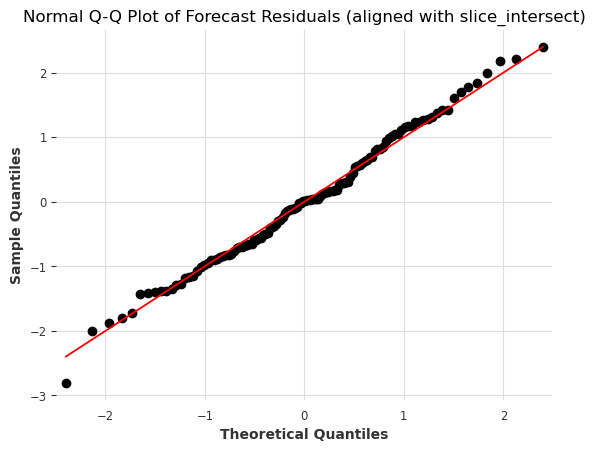

Shapiro-Wilk Test: Statistic=0.9923, p-value=0.7465
The residuals may be normally distributed (fail to reject the null hypothesis).


In [ ]:
# Use historical_forecasts with retrain=True to get fitted values
fitted_values = model.historical_forecasts(
    series,
    start=0, # Let Darts handle the warm-up period
    forecast_horizon=1,
    retrain=True,
    last_points_only=True
)

# Calculate residuals using slice_intersect() for robust alignment
# This is a concise and explicit way to handle the alignment.
residuals_series = series.slice_intersect(fitted_values) - fitted_values.slice_intersect(series)

# Convert to pandas Series and drop any NaN values that might remain
# (though slice_intersect() should prevent them)
residuals_series_pd = residuals_series.to_series().dropna()


# --- Graphical Checks ---
# 1. Histogram
plt.figure(figsize=(12, 6))
residuals_series_pd.plot.hist(bins=30, alpha=0.7, title='Histogram of Forecast Residuals (aligned with slice_intersect)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

# 2. Normal Q-Q Plot
plt.figure(figsize=(6, 6))
sm.qqplot(residuals_series_pd, line='s', fit=True)
plt.title('Normal Q-Q Plot of Forecast Residuals (aligned with slice_intersect)')
plt.show()

# --- Statistical Test ---
# 3. Shapiro-Wilk Test
shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals_series_pd)
print(f'Shapiro-Wilk Test: Statistic={shapiro_test_statistic:.4f}, p-value={shapiro_p_value:.4f}')

if shapiro_p_value > 0.05:
    print('The residuals may be normally distributed (fail to reject the null hypothesis).')
else:
    print('The residuals are likely not normally distributed (reject the null hypothesis).')
